In [1]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman', 'Times']
plt.rcParams['mathtext.fontset'] = 'stix'

import scipy.ndimage as ndi
from sionna.rt import load_scene, Transmitter, RadioMapSolver, Camera, PlanarArray, RadioMap, Scene
import sionna
import mitsuba as mi

from typing import Tuple, List, cast
from pathlib import Path
import os
from tqdm import tqdm

from dataclasses import dataclass

In [2]:
RM_SOLVER = RadioMapSolver()

In [3]:
@dataclass(frozen=True)
class TransmitterConfig:
    hr_grid_size: int = 512
    scale: int = 2
    tx_array_pattern: str = "iso"
    polarization: str = "V"
    coverage_size: float = 160.0

    hr_size = coverage_size / hr_grid_size
    lr_size = hr_size * scale

    hr_cell_size: tuple[float, float] = (hr_size, hr_size)
    lr_cell_size: tuple[float, float] = (lr_size, lr_size)
    
    grid_randomization: float = 1.0
    scene_grid_margin: float = 30.0
    n_tx: int = 1
    tx_default_height: float = 45.0
    tx_height_margin: float = 5.0
    tx_power_dbm: int = 44

    seed: int = 42
    metric_type: str = "path_gain"
    to_db: bool = True
    db_floor: float = -150.0
    db_ceiling: float = -50.0

    n_samples: int = 5

    def validate(self) -> "TransmitterConfig":
        if self.n_tx <= 0:
            raise ValueError("n_tx must be > 0.")
        if self.scale <= 1:
            raise ValueError("scale must be > 1.")
        if self.coverage_size <= 0:
            raise ValueError("coverage_size must be > 0.")
        if not (0.0 <= self.grid_randomization <= 1.0):
            raise ValueError("grid_randomization must be between 0.0 and 1.0.")
        return self

class SuperResolutionDataSample:
    """Training data sample for super-resolution"""

    sample_id: int
    scene_name: str
    tx_positions: np.ndarray  # Shape: (n_tx, 3)
    map_lr: np.ndarray   # Low resolution radio map
    map_hr: np.ndarray   # High resolution radio map
    scale: int  # Super-resolution scale factor
    metric_type: str  # Type of metric stored
    grid_info: dict
    config: TransmitterConfig
    height_map: np.ndarray | None
    building_mask: np.ndarray | None
    LoS_map: np.ndarray | None
    rendered_image: np.ndarray | None

    def __init__(
        self,
        sample_id: int,
        tx_positions: np.ndarray,
        map_lr: np.ndarray,
        map_hr: np.ndarray,
        scale: int,
        metric_type: str,
        grid_info: dict,
        config: TransmitterConfig,
        height_map: np.ndarray | None,
        building_mask: np.ndarray | None,
        LoS_map: np.ndarray | None,
        rendered_image: np.ndarray | None
    ) -> None:
        self.sample_id = sample_id
        self.tx_positions = tx_positions
        self.map_lr = map_lr
        self.map_hr = map_hr
        self.scale = scale
        self.metric_type = metric_type
        self.grid_info = grid_info
        self.config = config    
        self.height_map = height_map
        self.building_mask = building_mask
        self.LoS_map = LoS_map
        self.rendered_image = rendered_image

In [4]:
def prep_nearest_map(Z: np.ndarray) -> np.ndarray:
    """Precompute nearest valid (row, col) indices for every pixel."""
    valid = ~np.isnan(Z)
    nearest_idx = ndi.distance_transform_edt(
        ~valid, return_distances=False, return_indices=True
    )
    nearest_map = np.asarray(nearest_idx)

    return nearest_map 


def world_to_index(x: float, y: float, tx_grid_info: dict) -> tuple[int, int]:
    """Convert world position to height map index"""
    # Retrive grid information
    xmin = tx_grid_info["xmin"] # minimum x coordinate
    ymin = tx_grid_info["ymin"] # minimum y coordinate
    nx = tx_grid_info["nx"]     # number of points in x direction
    ny = tx_grid_info["ny"]     # number of points in y direction
    h = tx_grid_info["h"]       # grid step size

    # Convert world position to height map index
    row_index = int(np.clip(np.round((y - ymin) / h), 0, ny - 1))  # row (y)
    col_index = int(np.clip(np.round((x - xmin) / h), 0, nx - 1))  # col (x)
    return row_index, col_index


def _index_to_world(row_index: int, col_index: int, tx_grid_info: dict) -> tuple[float, float]:
    """Convert height map indices to world coordinates"""
    # Retrive grid information
    xmin = tx_grid_info["xmin"] # minimum x coordinate
    ymin = tx_grid_info["ymin"] # minimum y coordinate
    h = tx_grid_info["h"]       # grid step size

    # Convert to height map index to world postion
    x = xmin + col_index * h
    y = ymin + row_index * h

    return x, y


def snap_to_nearest_valid_position(position: List[float], tx_grid_info: dict) -> List[float]:
    """Snap world coordinates to nearest valid height map point"""
    # Retrieve current transmitter position
    x_current, y_current, _ = position

    # Convert world position to height map index
    row_index, col_index = world_to_index(x_current, y_current, tx_grid_info)

    # Get nearest index with valid height
    # If (col_index, row_index) is already valid then (col_index, row_index) = (valid_col_index, valid_row_index)
    valid_row_index, valid_col_index = tx_grid_info["nearest_idx"][:, row_index, col_index]

    z = tx_grid_info["height_map"][valid_row_index, valid_col_index]
    x, y = _index_to_world(valid_row_index, valid_col_index, tx_grid_info)

    return [float(x), float(y), float(z)]


def plot_height_map(
    Z: np.ndarray | None, 
    meta: dict[str, float],
    txs: dict[str, dict[str, float | str]] | None = None,
    cmap: str = 'viridis',
    title: str = 'Ray-casted height map',
    xlabel: str = 'x (m)',
    ylabel: str = 'y (m)',
    colorbar_label: str = 'Height (m)',
    show_title: bool = True,
    show_axis: bool = True,
    show_colorbar: bool = True,
    ) -> None:
    """Plot top-down view of the height map."""
    if Z is None:
        raise ValueError("Height map Z is None.")
    
    plt.figure(figsize=(6, 5))
    im = plt.imshow(
            Z,
            origin="lower",
            cmap=cmap,
            extent=(float(meta["xmin"]), float(meta["xmax"]), float(meta["ymin"]), float(meta["ymax"]))
    )

    if txs is not None:
        for label, data in txs.items():
            x = data["x"]
            y = data["y"]
            color = data.get("color", None)
            plt.scatter(x, y, label=label, s=35, edgecolors="black", linewidths=0.5, color=color)
        plt.legend()

    if show_colorbar:
        plt.colorbar(im, label=colorbar_label)

    if show_axis:
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
    else:
        plt.axis("off")

    if show_title:
        plt.title(title)

    plt.tight_layout()
    plt.show()


def height_map_ray_casting(
        scene: "Scene",
        direction: tuple[float, float, float],
        step_size_power: int = 10,
        step_size_exponent: int = 0,
        disc_info: dict | None = None
        ) -> tuple[np.ndarray, dict[str, float]]:
    """
    Generate height map using ray casting method. 
    If disc_info is provided the height map is generated based on the provided discretization info.
    Otherwise, the height map is generated based on the step size parameters and scene bounding box.
    """
    if direction not in [(0.0, 0.0, -1.0), (0.0, 0.0, 1.0)]:
        raise ValueError("Direction must be either (0.0, 0.0, -1.0) for downward or (0.0, 0.0, 1.0) for upward ray casting.")

    # Get scene bounding box
    if getattr(scene, "mi_scene", None) is None:
        raise ValueError("Scene is not properly initialized. 'Scene' object does not have 'mi_scene' attribute.")
    
    mi_scene = cast("mi.Scene", scene.mi_scene)    # to avoid type checker warning

    if getattr(mi_scene, "bbox", None) is None:
        raise ValueError("Scene is not properly initialized. 'mi_scene' object does not have 'bbox' attribute.")
    
    bbox = mi_scene.bbox()

    if disc_info is None:
        # Calculate grid step size
        h = step_size_power ** step_size_exponent
        xmin, xmax = float(bbox.min.x), float(bbox.max.x)
        ymin, ymax = float(bbox.min.y), float(bbox.max.y)
        z_top = float(bbox.max.z)

        # Generate ray origins on a grid above the scene
        x_vals = np.arange(xmin, xmax + h, h)
        y_vals = np.arange(ymin, ymax + h, h)
        nx, ny = len(x_vals), len(y_vals)
    else:
        xmin = disc_info["xmin"]
        xmax = disc_info["xmax"]
        ymin = disc_info["ymin"]
        ymax = disc_info["ymax"]
        h = disc_info["h"]
        nx = disc_info["nx"]
        ny = disc_info["ny"]
        z_top = disc_info.get("zmax", float(bbox.max.z))

        # Generate ray origins on a grid above the scene
        x_vals = np.linspace(xmin, xmax, nx)
        y_vals = np.linspace(ymin, ymax, ny)

    # Create meshgrid for ray origins
    X, Y = np.meshgrid(x_vals, y_vals)
    Xf = X.ravel()
    Yf = Y.ravel()
    Zf = np.full(X.size, -z_top * direction[2])

    # Cast rays and get intersection points
    ray = mi.Ray3f(
        o=mi.Point3f(Xf, Yf, Zf),
        d=mi.Vector3f(*direction)
        )
    scene_intersect = mi_scene.ray_intersect(ray)    
    z_hit = scene_intersect.p.z
    valid = scene_intersect.is_valid()
    mask = valid

    # Reshape results into height map
    z_np = np.array(z_hit, dtype=float)
    mask_np = np.array(mask, dtype=bool)
    z_np[~mask_np] = np.nan

    Z = z_np.reshape(ny, nx)
    meta = {
        "xmin": xmin, "xmax": xmax,
        "ymin": ymin, "ymax": ymax,
        "h": h, "nx": nx, "ny": ny
    }
    return Z, meta


def generate_scene_height_map(
        scene: "Scene",
        min_object_height: float | None = 10.0
        ) -> np.ndarray | tuple[np.ndarray, dict]:
        """Generate height map of the scene using ray casting"""        
        # Ray casting in downward direction
        Z, meta = height_map_ray_casting(scene=scene, direction=(0.0, 0.0, -1.0))
        mask = ~np.isnan(Z)

        if min_object_height is not None:
            # Ray cast in upward direction to determine ground height
            ground_height, _ = height_map_ray_casting(scene=scene, direction=(0.0, 0.0, 1.0))

            # Determine valid relative heights
            height_above_ground = Z - ground_height
            mask &= ~(~np.isnan(height_above_ground) & (height_above_ground < min_object_height))
        # Apply mask to height map
        Z[~mask] = np.nan

        return Z, meta


def get_sample_disc_info(rm: "RadioMap", config: TransmitterConfig) -> dict:
    """Get discretization info from a RadioMap object"""
    center = getattr(rm, "center")
    size = getattr(rm, "size")
    cell_size = getattr(rm, "cell_size")

    if cell_size is None:
        raise ValueError("Radio map object does not have 'cell_size' attribute.")
    if center is None:
        raise ValueError("Radio map object does not have 'center' attribute.")
    if size is None:
        raise ValueError("Radio map object does not have 'size' attribute.")

    disc_info = {
        "xmin": center[0][0] - config.coverage_size / 2,
        "xmax": center[0][0] + config.coverage_size / 2,
        "ymin": center[1][0] - config.coverage_size / 2,
        "ymax": center[1][0] + config.coverage_size / 2,
        "h": cell_size[0][0],
        "nx": int(size[0][0] / cell_size[0][0]),
        "ny": int(size[1][0] / cell_size[1][0]),
    }
    return disc_info


def generate_sample_height_map(
        scene: "Scene", 
        disc_info: dict, 
        return_building_mask: bool = True,
        return_los_map: bool = True,
    ) -> tuple[np.ndarray, np.ndarray | None, np.ndarray | None]:
    """
    Generate sample height map using ray casting based on provided discretization info.
    If return_los_map is True: returns (height_map, building_mask, los_map).
    If return_building_mask is True: returns (height_map, building_mask, None).
    Else: returns (height_map, None, None).
    """

    # Initialize optional return values
    building_mask: np.ndarray | None = None
    los_map: np.ndarray | None = None

    # Generate height map using downward ray casting over the sample area
    height_map, _ = height_map_ray_casting(scene=scene, direction=(0.0, 0.0, -1.0), disc_info=disc_info)

    # Here, both building_mask and los_map are returned since they are needed for LoS map generation
    if return_los_map:
        building_mask, ground_height_map = generate_building_mask(scene, height_map, disc_info)
        los_map = generate_LoS_map(scene, disc_info, ground_height_map)
    
    # If only building mask is requested, skip LoS map generation
    elif return_building_mask and not return_los_map:
        building_mask, _ = generate_building_mask(scene, height_map, disc_info)
    
    return height_map, building_mask, los_map
    
def generate_building_mask(
        scene: "Scene",
        height_map: np.ndarray,
        disc_info: dict,
    ) -> tuple[np.ndarray, np.ndarray]:
    """
    Generate building mask from height map based on height threshold.
    Returns a building mask and ground height map.
    """
    # Ray cast in upward direction to determine ground height
    ground_height_map, _ = height_map_ray_casting(scene=scene, direction=(0.0, 0.0, 1.0), disc_info=disc_info)

    # Determine building mask based on height above ground
    height_above_ground = height_map - ground_height_map

    # Determine building mask based on height above ground
    building_mask = (~np.isnan(height_above_ground) & (height_above_ground > 0.1))

    return building_mask, ground_height_map

def generate_LoS_map(
        scene: "Scene",
        disc_info: dict,
        ground_height_map: np.ndarray,
        threshold: float = 0.000_1
        ) -> np.ndarray:
    """
    Generate sample LoS map from height map.
    The LoS is determined by shooting rays from the transmitter to each grid point in the ground height map.
    The LoS is True if the ray hits the ground before any other object.
    The rays are shot towards the ground since we are ameasuring the path gain at ground level.
    """
    # Check scene and transmitter initialization
    if getattr(scene, "mi_scene", None) is None:
        raise ValueError("Scene is not properly initialized. 'Scene' object does not have 'mi_scene' attribute.")
    
    mi_scene = cast("mi.Scene", scene.mi_scene)    # to avoid type checker warning

    if getattr(mi_scene, "bbox", None) is None:
        raise ValueError("Scene is not properly initialized. 'mi_scene' object does not have 'bbox' attribute.")
    
    if not scene.transmitters:
        raise ValueError("Scene transmitter is not properly initialized. No 'Transmitter' objects exist.")

    tx = next(iter(scene.transmitters.values()))

    xmin = disc_info["xmin"]
    xmax = disc_info["xmax"]
    ymin = disc_info["ymin"]
    ymax = disc_info["ymax"]
    nx = disc_info["nx"]
    ny = disc_info["ny"]

    # Create meshgrid for receiver positions
    x_vals = np.linspace(xmin, xmax, nx)
    y_vals = np.linspace(ymin, ymax, ny)
    X, Y = np.meshgrid(x_vals, y_vals)

    if ground_height_map.shape != (ny, nx):
        raise ValueError("Ground height map shape does not match the " \
                        f"expected shape from discretization info. Expected ({ny}, {nx}), " \
                        f"got {ground_height_map.shape}.")
    
    Xf = X.ravel()
    Yf = Y.ravel()
    Zf = ground_height_map.ravel()
    valid_ground = ~np.isnan(Zf)
    if not np.any(valid_ground):
        return np.zeros((ny, nx), dtype=bool)
    
    Xv = Xf[valid_ground]
    Yv = Yf[valid_ground]
    Zv = Zf[valid_ground]  # add 1m to ground height for receiver position

    # Create ray origins at transmitter position
    ray_origins = mi.Point3f(
        np.full_like(X.size, tx.position.x[0]),
        np.full_like(X.size, tx.position.y[0]),
        np.full_like(X.size, tx.position.z[0]),
    )

    # Create ray directions towards each grid point
    dx = Xv - tx.position.x[0]
    dy = Yv - tx.position.y[0]
    dz = Zv - tx.position.z[0]
    L  = np.sqrt(dx * dx + dy * dy + dz * dz)

    ray_directions = mi.Vector3f(
        dx / L,
        dy / L,
        dz / L
    )

    # Create rays
    ray = mi.Ray3f(
        o=ray_origins,
        d=ray_directions
    )
    
    scene_intersect = mi_scene.ray_intersect(ray)    
    # valid = scene_intersect.is_valid()

    # Check which rays hit the ground by comparing height of scene intersection points with ground height
    z_hit = scene_intersect.p.z
    z_hit_valid = np.array(z_hit, dtype=float)[valid_ground] < np.array(Zv, dtype=float) + threshold
    # z_hit_valid = np.array(z_hit, dtype=float)[valid_ground] == np.array(Zv, dtype=float)
    los_valid = np.zeros(X.size, dtype=bool)
    los_valid[valid_ground] = z_hit_valid

    los_map = np.array(los_valid, dtype=bool).reshape(ny, nx)

    return los_map

In [18]:
def generate_grid_positions(config: TransmitterConfig, scene_corners: tuple) -> Tuple[List[List[float]], dict]:
    """Generate transmitter positions and return grid info"""
    grid_dim = int(np.ceil(np.sqrt(config.n_tx)))

    # Determine grid center
    if scene_corners is not None:
        (x_min, x_max), (y_min, y_max) = scene_corners
        x_min += config.coverage_size / 2
        x_max -= config.coverage_size / 2
        y_min += config.coverage_size / 2
        y_max -= config.coverage_size / 2
        center_x = np.random.uniform(x_min, x_max)
        center_y = np.random.uniform(y_min, y_max)
    else:
        center_x, center_y = 0.0, 0.0

    grid_spacing = config.coverage_size / grid_dim

    # Calculate map bounds (full coverage area)
    map_xmin = center_x - config.coverage_size / 2
    map_xmax = center_x + config.coverage_size / 2
    map_ymin = center_y - config.coverage_size / 2
    map_ymax = center_y + config.coverage_size / 2

    # Grid info
    grid_info = {
        "center_x": center_x,
        "center_y": center_y,
        "map_bounds": [[map_xmin, map_xmax], [map_ymin, map_ymax]],
        "grid_spacing": grid_spacing,
        "grid_dim": grid_dim,
    }

    # Generate positions
    positions = []
    tx_count = 0

    for i in range(grid_dim):
        for j in range(grid_dim):
            if tx_count >= config.n_tx:
                break

            base_x = center_x + (i - grid_dim / 2 + 0.5) * grid_spacing
            base_y = center_y + (j - grid_dim / 2 + 0.5) * grid_spacing

            if config.grid_randomization > 0:
                rand_x = np.random.uniform(-grid_spacing / 2, grid_spacing / 2) * config.grid_randomization
                rand_y = np.random.uniform(-grid_spacing / 2, grid_spacing / 2) * config.grid_randomization
                base_x += rand_x
                base_y += rand_y

            positions.append([float(base_x), float(base_y), float(config.tx_default_height)])
            tx_count += 1

    return positions, grid_info

def get_scene_boundary(scene: "Scene", config: TransmitterConfig) -> tuple:
    """Get the boundary of the scene for transmitter placement"""
    if getattr(scene, "mi_scene", None) is None:
        raise ValueError("Scene is not properly initialized. 'Scene' object does not have 'mi_scene' attribute.")
    
    mi_scene = cast("mi.Scene", scene.mi_scene)    # to avoid type checker warning

    if getattr(mi_scene, "bbox", None) is None:
        raise ValueError("Scene is not properly initialized. 'mi_scene' object does not have 'bbox' attribute.")
    
    bbox = mi_scene.bbox()
    x_min = bbox.min.x
    x_max = bbox.max.x
    y_min = bbox.min.y
    y_max = bbox.max.y

    # add margin
    x_min += config.scene_grid_margin
    x_max -= config.scene_grid_margin
    y_min += config.scene_grid_margin
    y_max -= config.scene_grid_margin

    return ((x_min, x_max), (y_min, y_max))

def safe_remove(scene: "Scene", name: str):
    try:
        scene.remove(name)
    except Exception:
        pass

def clear_previous(scene: "Scene", max_scan: int = 100):
    """Clear any previous transmitters"""
    for i in range(1, max_scan + 1):
        safe_remove(scene, f"tx_{i}")

def build(
        scene: "Scene",
        config: TransmitterConfig,
        scene_corners: tuple,
        tx_grid_info: dict | None = None
    ) -> tuple[List[List[float]], dict]:
        """Build transmitters on the scene"""
        config = config.validate()

        if config.seed is not None:
            np.random.seed(config.seed)

        # Clear previous transmitters
        clear_previous(scene)
    
        # Set up transmitter array
        scene.tx_array = PlanarArray(
            num_rows=1,
            num_cols=1,
            pattern=config.tx_array_pattern,
            polarization=config.polarization,
        )

        # Generate transmitter positions
        tx_positions, grid_info = generate_grid_positions(config, scene_corners)

        # Create transmitters
        for i, pos in enumerate(tx_positions, start=1):
            # Validate current transmitter position
            if tx_grid_info is not None:
                pos = snap_to_nearest_valid_position(pos, tx_grid_info)
                pos[2] += config.tx_height_margin
                tx_positions[i - 1] = pos

            name = f"tx_{i}"
            scene.add(Transmitter(name=name,
                                  position=mi.Point3f(pos),
                                  power_dbm=config.tx_power_dbm,
                                  color=(0, 0, 1))
                                  )

        return tx_positions, grid_info

def extract_metric(radio_map: "RadioMap", metric_type: str) -> np.ndarray:
    """Extract the specified metric from the radio map"""
    if metric_type == "path_gain":
        return radio_map.path_gain
    elif metric_type == "rss":
        return radio_map.rss
    elif metric_type == "sinr":
        return radio_map.sinr
    else:
        raise ValueError(f"Unsupported metric type: {metric_type}")
    
def apply_db_conversion(radio_map: np.ndarray, config: TransmitterConfig, dbm: bool = False) -> np.ndarray:
        """Apply dB conversion to the radio map"""
        radio_map_db = 10.0 * np.log10(np.clip(radio_map, a_min=1e-15, a_max=None))
        if dbm:
            radio_map_db += 30.0  # Convert to dBm
        if config.db_floor is not None:
            radio_map_db = np.clip(radio_map_db, a_min=config.db_floor, a_max=config.db_ceiling)
        return radio_map_db

def generate_sample(
    scene: "Scene",
    sample_id: int,
    config: TransmitterConfig,
    scene_corners: tuple,
    tx_grid_info: dict | None = None,
) -> SuperResolutionDataSample:
    """Generate a single super-resolution data sample"""

    # Build transmitters in scene
    tx_positions, grid_info = build(scene, config, scene_corners, tx_grid_info)
    tx_positions = np.asarray(tx_positions)
    cx, cy = grid_info["center_x"], grid_info["center_y"]

    # Generate LOW RESOLUTION radio map
    rm_lr = RM_SOLVER(
        scene,
        max_depth=5,
        samples_per_tx=10**6,
        cell_size=mi.Point2f(config.lr_cell_size),
        center=mi.Point3f([cx, cy, 0.0]),
        size=mi.Point2f([config.coverage_size, config.coverage_size]),
        orientation=mi.Point3f([0, 0, 0]),
    )

    rm_hr = RM_SOLVER(
        scene,
        max_depth=5,
        samples_per_tx=10**6,
        cell_size=mi.Point2f(config.hr_cell_size),
        center=mi.Point3f([cx, cy, 0.0]),
        size=mi.Point2f([config.coverage_size, config.coverage_size]),
        orientation=mi.Point3f([0, 0, 0]),
    )

    # Extract the specified metric
    metric_lr = extract_metric(rm_lr, metric_type=config.metric_type)
    metric_hr = extract_metric(rm_hr, metric_type=config.metric_type)

    # Assume one transmitter for now
    map_lr = np.max(metric_lr, axis=0)
    map_hr = np.max(metric_hr, axis=0)

    if config.to_db:
        if config.metric_type == "path_gain" or config.metric_type == "sinr":
            map_lr = apply_db_conversion(map_lr, config=config, dbm=False)
            map_hr = apply_db_conversion(map_hr, config=config, dbm=False)
        elif config.metric_type == "rss":
            map_lr = apply_db_conversion(map_lr, config=config, dbm=True)
            map_hr = apply_db_conversion(map_hr, config=config, dbm=True)

    # Generate sample height map, building mask, and LoS map for alternative input channels
    sample_height_map, sample_building_mask, sample_LoS_map = generate_sample_height_map(
        scene=scene,
        disc_info=get_sample_disc_info(rm_lr, config),
        return_building_mask=True,
        return_los_map=True
    )

    # Render radio map as image from camera perspective
    rendered_image = scene.render(
        camera=Camera(
            position=mi.Point3f([getattr(rm_lr, "center")[0][0], getattr(rm_lr, "center")[1][0], 300]),
            look_at=mi.Point3f([getattr(rm_lr, "center")[0][0], getattr(rm_lr, "center")[1][0], 0])
        ),
        radio_map=rm_lr,
        fov=30.0,
        resolution=(256, 256),
        show_devices=True,
        return_bitmap=True,
        rm_metric="path_gain",
        rm_vmax=np.max(map_lr),
        rm_vmin=np.min(map_lr)
        )
    rendered_image = np.array(rendered_image)
    rendered_image = np.rot90(rendered_image, k=-1)
    rendered_image = np.flipud(rendered_image)
            
    # Create sample
    sample = SuperResolutionDataSample(
        sample_id=sample_id,
        tx_positions=tx_positions,
        map_lr=map_lr,
        map_hr=map_hr,
        scale=config.scale,
        metric_type=config.metric_type,
        grid_info=grid_info,
        config=config,
        # Data for alternative input channels
        height_map=sample_height_map,
        building_mask=sample_building_mask,
        LoS_map=sample_LoS_map,
        # Rendered radio map image
        rendered_image=rendered_image,
        )

    return sample

def generate_tx_grid_info(scene: "Scene") -> dict:
    """Generate transmitter grid info based on scene geometry"""

    # Generate height map and discretization info
    height_map, discretization_info = generate_scene_height_map(scene=scene)

    # Generate "nearest valid neighbor" indexes for NaN values
    valid = ~np.isnan(height_map)
    nearest_idx = ndi.distance_transform_edt(~valid, return_distances=False, return_indices=True)
    nearest_idx = np.array(nearest_idx)

    # Store transmitter grid info
    tx_grid_info = {
        "xmin": discretization_info["xmin"], # minimum x coordinate
        "xmax": discretization_info["xmax"], # maximum x coordinate
        "ymin": discretization_info["ymin"], # minimum y coordinate
        "ymax": discretization_info["ymax"], # maximum y coordinate
        "nx":   discretization_info["nx"],   # number of points in x direction
        "ny":   discretization_info["ny"],   # number of points in y direction
        "h":    discretization_info["h"],    # grid step size
        "height_map": height_map,            # height map matrix
        "nearest_idx": nearest_idx,          # nearest valid neighbor indexes
    }
    return tx_grid_info

def save_data(sample: SuperResolutionDataSample, save_dir: str | Path, naming: str) -> None:
    """Save a single data sample to disk as PNG image"""
    if isinstance(save_dir, str):
        save_dir = Path(save_dir)
    
    save_dir = save_dir / naming
    os.makedirs(save_dir, exist_ok=True)
    sample_path = os.path.join(save_dir, f"sample{sample.sample_id:04d}.png")
    
    # Subplot LR and HR maps, height map, building mask, and LoS map
    n_rows = 2
    n_cols = 3

    # Create subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 5 * n_rows))

    # Low resolution
    im0 = axes[0, 0].imshow(sample.map_lr, origin="lower", cmap="viridis")
    axes[0, 0].set_title(f"Low Resolution Map ({sample.metric_type})")
    fig.colorbar(im0, ax=axes[0, 0], label="dB")
    
    # High resolution
    im1 = axes[0, 1].imshow(sample.map_hr, origin="lower", cmap="viridis")
    axes[0, 1].set_title(f"High Resolution Map ({sample.metric_type})")
    fig.colorbar(im1, ax=axes[0, 1], label="dB")

    # Rendered radio map
    im2 = axes[0, 2].imshow(sample.rendered_image, origin="lower")
    axes[0, 2].set_title("Rendered Radio Map")
    # axes[0, 2].axis("off")
    fig.colorbar(im0, ax=axes[0, 2], label="dB")

    # Height map
    im3 = axes[1, 0].imshow(sample.height_map, origin="lower", cmap="terrain")
    axes[1, 0].set_title("Height Map")
    fig.colorbar(im3, ax=axes[1, 0], label="Height (m)")

    # Building mask
    im4 = axes[1, 1].imshow(sample.building_mask, origin="lower", cmap="gray")
    axes[1, 1].set_title("Building Mask")
    fig.colorbar(im4, ax=axes[1, 1], label="Building Presence")

    # LoS map
    im5 = axes[1, 2].imshow(sample.LoS_map, origin="lower", cmap="gray")
    axes[1, 2].set_title("LoS Map")
    fig.colorbar(im5, ax=axes[1, 2], label="LoS Presence")

    plt.tight_layout()
    plt.savefig(sample_path)
    plt.close(fig)


def get_scene(scene_name: str) -> "Scene":
    if scene_name == "etoile":
        scene = load_scene(sionna.rt.scene.etoile, merge_shapes=False)
    elif scene_name == "san_francisco":
        scene = load_scene(sionna.rt.scene.san_francisco, merge_shapes=False)
    elif scene_name == "munich":
        scene = load_scene(sionna.rt.scene.munich, merge_shapes=False)
    elif scene_name == "florence":
        scene = load_scene(sionna.rt.scene.florence, merge_shapes=False)
    else:
        raise ValueError(f"Unknown scene: {scene_name}")
    return scene


def generate_dataset(
    scene_name: str,
    base_config: TransmitterConfig,
    dataset_path: str | Path,
    show_progress: bool = True,
) -> None:
    """Generate multiple super-resolution data samples"""
    # Load scene
    scene = get_scene(scene_name)

    print(f"Generating {base_config.n_samples} super-resolution samples for {scene_name}...")
    print(f"Metric: {base_config.metric_type}, Scale: {base_config.scale}x")
    print(f"LR cell: {base_config.lr_cell_size}, HR cell: {base_config.hr_cell_size}")
    print(f"Coverage: {base_config.coverage_size}x{base_config.coverage_size}m")

    if isinstance(dataset_path, str):
        dataset_path = Path(dataset_path)
    os.makedirs(dataset_path, exist_ok=True)

    print(f"Samples will be saved to: {dataset_path / scene_name}")

    # Get boundaries of the scene
    scene_corners = get_scene_boundary(scene, base_config)

    iterator = tqdm(range(base_config.n_samples), desc="Generating samples") \
                if show_progress else range(base_config.n_samples)

    tx_grid_info = generate_tx_grid_info(scene)

    for i in iterator:
        # Create config with unique seed for each sample
        from dataclasses import replace

        config = replace(base_config, seed=i + 200)

        sample = generate_sample(scene, i + 1, config, scene_corners, tx_grid_info)
        save_data(sample, dataset_path, naming=scene_name)

        if show_progress and isinstance(iterator, tqdm):
            iterator.set_postfix(
                {
                    "LR": str(tuple(sample.map_lr.shape)),
                    "HR": str(tuple(sample.map_hr.shape)),
                    "Height Map": str(tuple(sample.height_map.shape)) if sample.height_map is not None else "None",
                    "Building Mask": str(tuple(sample.building_mask.shape)) if sample.building_mask is not None else "None",
                    "LoS Map": str(tuple(sample.LoS_map.shape)) if sample.LoS_map is not None else "None",
                }
            )

### Following shows a single sample test of height map, building mask, and LoS map generation for a given transmitter position in the scene.

In [6]:
scene = load_scene(sionna.rt.scene.etoile, merge_shapes=False)
config = TransmitterConfig()

In [7]:
scene.remove("TX")
scene.add(Transmitter(
    name="TX",
    position=mi.Point3f([-60, 10, 20]),
    power_dbm=config.tx_power_dbm,
    color=(0, 0, 1))
)
scene.tx_array = PlanarArray(
    num_rows=1,
    num_cols=1,
    pattern=config.tx_array_pattern,
    polarization=config.polarization,
)

rm = RM_SOLVER(
    scene=scene,
    max_depth=5,
    samples_per_tx=10**6,
    cell_size=mi.Point2f(config.lr_cell_size),
    center=mi.Point3f([-115, 32, 0]),
    size=mi.Point2f([config.coverage_size, config.coverage_size]),
    orientation=mi.Point3f([0, 0, 0]),
)

In [8]:
im = extract_metric(rm, metric_type=config.metric_type)
im_db = apply_db_conversion(im, config=config, dbm=True)

In [9]:
disc_info = get_sample_disc_info(rm, config)
sample_height_map, sample_building_mask, sample_los_map = \
                    generate_sample_height_map(scene, disc_info, return_building_mask=True, return_los_map=True)

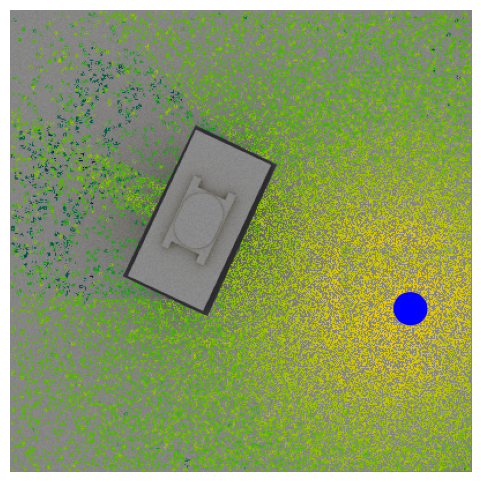

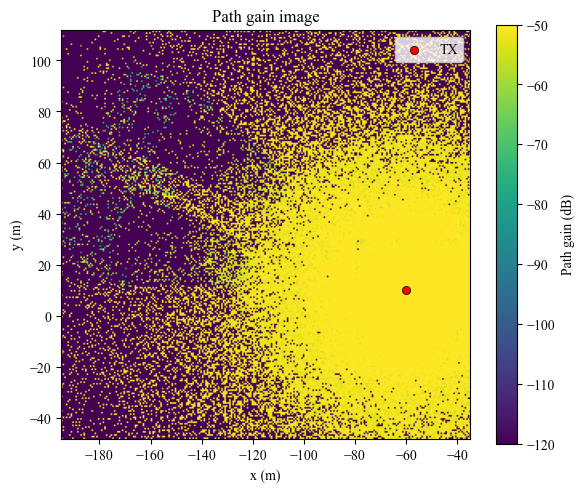

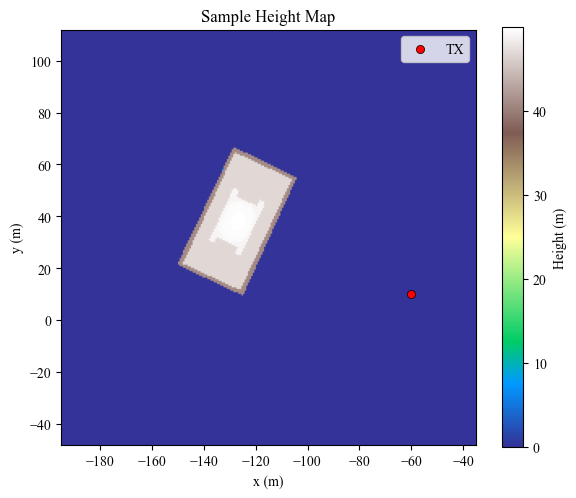

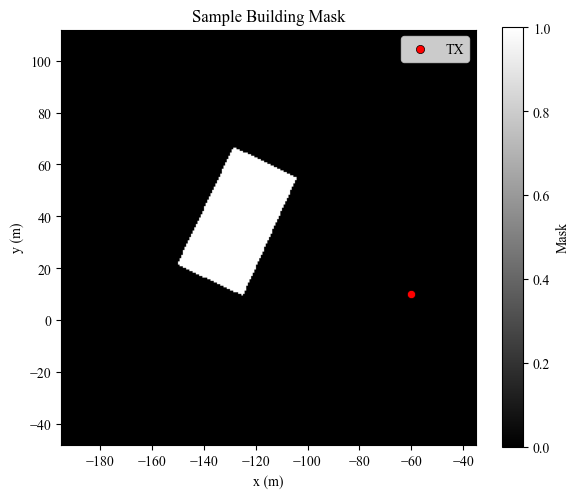

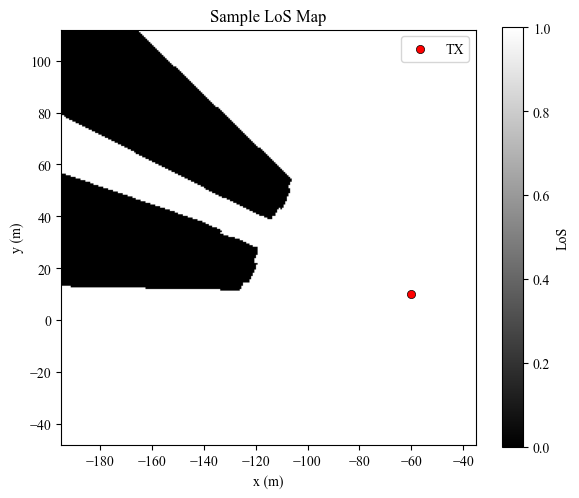

In [10]:
s = scene.render(
    camera=Camera(
        position=mi.Point3f([getattr(rm, "center")[0][0], getattr(rm, "center")[1][0], 300]),
        look_at=mi.Point3f([getattr(rm, "center")[0][0], getattr(rm, "center")[1][0], 0])
    ),
    radio_map=rm,
    fov=30.0,
    resolution=(400, 400),
    show_devices=True,
    return_bitmap=True,
    rm_show_color_bar=True,
    )
s = np.array(s)
s = np.rot90(s, k=-1)
plt.figure(figsize=(6, 6))
plt.imshow(s)
plt.axis('off')
plt.show()

plot_height_map(
    Z=im_db[0],
    meta=disc_info,
    title="Path gain image",
    colorbar_label="Path gain (dB)",
    txs={
        "TX": {"x": -60, "y": 10, "color": "red"}
    },
    cmap="viridis"
)

plot_height_map(
    Z=sample_height_map,
    meta=disc_info,
    title="Sample Height Map",
    colorbar_label="Height (m)",
    txs={
        "TX": {"x": -60, "y": 10, "color": "red"}
    },
    cmap="terrain"
)

plot_height_map(
    Z=sample_building_mask,
    meta=disc_info,
    title="Sample Building Mask",
    colorbar_label="Mask",
    txs={
        "TX": {"x": -60, "y": 10, "color": "red"}
    },
    cmap="gray"
)
plot_height_map(
    Z=sample_los_map,
    meta=disc_info,
    title="Sample LoS Map",
    colorbar_label="LoS",
    txs={
        "TX": {"x": -60, "y": 10, "color": "red"}
    },
    cmap="gray"
)

In [ ]:
# Generate png images of super-resolution dataset samples
for name in ["etoile"]:  # "etoile", "san_francisco", "munich", "florence"
    generate_dataset(
        scene_name = name,
        base_config = TransmitterConfig(),
        dataset_path = Path(os.getcwd()) / "test_sample_data_generation",
        show_progress = True
    )

Generating 5 super-resolution samples for etoile...
Metric: path_gain, Scale: 2x
LR cell: (0.625, 0.625), HR cell: (0.3125, 0.3125)
Coverage: 160.0x160.0m
Samples will be saved to: c:\Users\marwi\Desktop\RaySR\test_data_generation\etoile


Generating samples: 100%|██████████| 5/5 [06:47<00:00, 81.50s/it, LR=(256, 256), HR=(512, 512), Height Map=(256, 256), Building Mask=(256, 256), LoS Map=(256, 256)] 
